In [1]:
# fmt: off
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "06_preprocessing/06c_reuse_layers.ipynb"
_nb_title = "Reproducibility by Reusing Layers"

_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))
# fmt: on

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=Reproducibility+by+Reusing+Layers&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F06_preprocessing%2F06c_reuse_layers.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/06_preprocessing/06c_reuse_layers.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/06_preprocessing/06c_reuse_layers.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/06_preprocessing/06c_reuse_layers.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# 再利用可能なKeras層への前処理の組み込み

このノートブックでは、できるだけ多くの前処理をモデルに含める方法を確認します。

## GPUの有効化、ヘルパー関数の設定

GPUを使用することで、このノートブックを含むこのリポジトリ内のほとんどすべてのノートブックをより高速に実行することができます。

Colab:
- [Edit]→[Notebook Setting]へ移動
- [Hardware Accelerator]ドロップダウンから[GPU]を選択

Vertex AI Workbench:  
- https://console.cloud.google.com/vertex-ai/workbench/list/instances に移動
- [New Notebook] -> [TensorFlow Enterprise] -> [TensorFlow Enterprise 2.8] -> [With 1 NVIDIA Tesla T4] -> [Install NVIDIA GPU driver automatically for me]にチェック -> [Create] でインスタンスを作成

## TPUまたはGPUの検出

In [ ]:
import tensorflow as tf

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

## 前処理関数 `_Preprocessor`  

このクラスには、学習と推論の両方で明示的に適用する必要がある前処理関数を含めます。

In [2]:
# Helper functions
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])

In [3]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

class _Preprocessor:    
    def __init__(self):
        # nothing to initialize
        pass
    
    def read_from_tfr(self, proto):
        feature_description = {
            'image': tf.io.VarLenFeature(tf.float32),
            'shape': tf.io.VarLenFeature(tf.int64),
            'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }
        rec = tf.io.parse_single_example(
            proto, feature_description
        )
        shape = tf.sparse.to_dense(rec['shape'])
        img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
        label_int = rec['label_int']
        return img, label_int
    
    def read_from_jpegfile(self, filename):
        # same code as in 05_create_dataset/jpeg_to_tfrecord.py
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
      
    def preprocess(self, img):
        return tf.image.resize_with_pad(img, 2*IMG_HEIGHT, 2*IMG_WIDTH)
    
def create_preproc_dataset(pattern):
    preproc = _Preprocessor()
    trainds = tf.data.TFRecordDataset(
        [filename for filename in tf.io.gfile.glob(pattern)],
        compression_type='GZIP'
    ).map(preproc.read_from_tfr).map(
        lambda img, label: (preproc.preprocess(img), label))                             
    return trainds

def create_preproc_image(filename):
    preproc = _Preprocessor()
    img = preproc.read_from_jpegfile(filename)
    return preproc.preprocess(img)    

TensorFlow Recordsデータセットから読み込んだデータで`_Preprocessor`の挙動を確認しましょう。

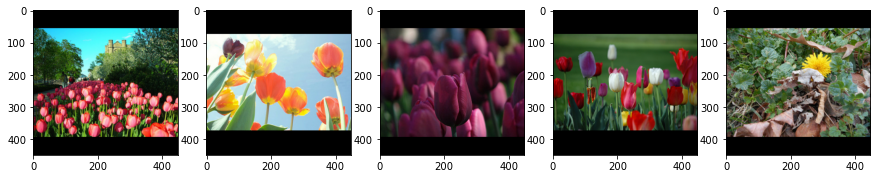

In [5]:
# preprocessing records read from a TensorFlow dataset
trainds = create_preproc_dataset('gs://practical-ml-vision-book-data/flowers_tfr/train-*')
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, (img, label) in enumerate(trainds.take(5)):
    ax[idx].imshow((img.numpy()));

続いて、個々のJPEGファイルの読み込みを確認します。

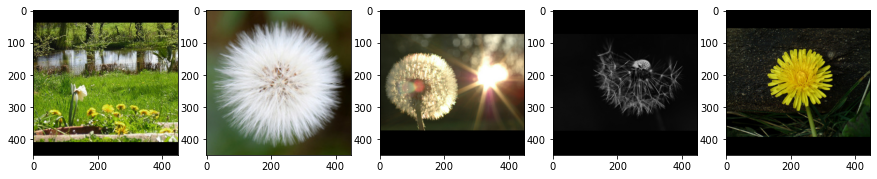

In [6]:
# preprocessing a single image
filenames = [
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/98992760_53ed1d26a9.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9939430464_5f5861ebab.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9965757055_ff01b5ee6f_n.jpg'
]
input_images = [create_preproc_image(f) for f in filenames]

f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, img in enumerate(input_images):
    ax[idx].imshow((img.numpy()));

## MobileNetによる転移学習  

MobileNetを使用した転移学習を行い、End-to-endで挙動を確認します。<br>
前処理用の層が加えられていることに注目してください。

In [9]:
import tensorflow_hub as hub
import os

os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'UNCOMPRESSED'

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
    
    # WARNING! training on a small subset dataset (note pattern)
    train_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book-data/flowers_tfr/train-0000*'
    ).batch(batch_size)
    eval_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book-data/flowers_tfr/valid-0000*'
    ).batch(batch_size)

    layers = [
      tf.keras.layers.CenterCrop(
          height=IMG_HEIGHT, width=IMG_WIDTH,
          input_shape=(2*IMG_HEIGHT, 2*IMG_WIDTH, IMG_CHANNELS),
      ),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    ]

    model = tf.keras.Sequential(layers, name='flower_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=3)
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "flower_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 center_crop_1 (CenterCrop)  (None, 224, 224, 3)       0         
                                                                 
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_hidden (Dense)        (None, 16)                20496     
                                                                 
 flower_prob (Dense)         (None, 5)                 85        
                                                                 
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/3
57/57 [==============================] - 18s 235ms/step - loss: 0.9177 - accuracy

2022-07-11 17:07:17.644141: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 1969, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657559237.644031155","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 1969, Output num: 0","grpc_status":3}


57/57 [==============================] - 13s 223ms/step - loss: 0.4254 - accuracy: 0.8578 - val_loss: 0.4656 - val_accuracy: 0.8342
Epoch 3/3
57/57 [==============================] - 13s 223ms/step - loss: 0.2949 - accuracy: 0.9040 - val_loss: 0.4158 - val_accuracy: 0.8523


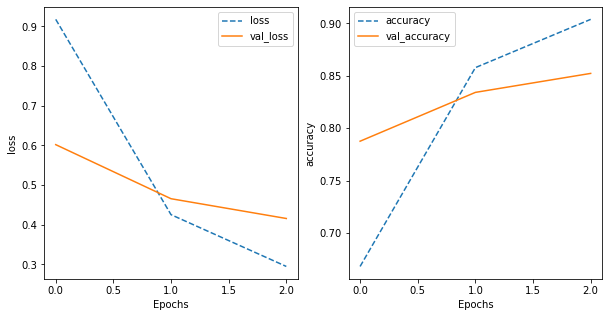

In [10]:
model = train_and_evaluate()

2022-07-11 17:08:37.815118: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: INVALID_ARGUMENT: Unable to find the relevant tensor remote_handle: Op ID: 3451, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1657559317.815027323","description":"Error received from peer ipv4:10.112.92.178:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 3451, Output num: 1","grpc_status":3}


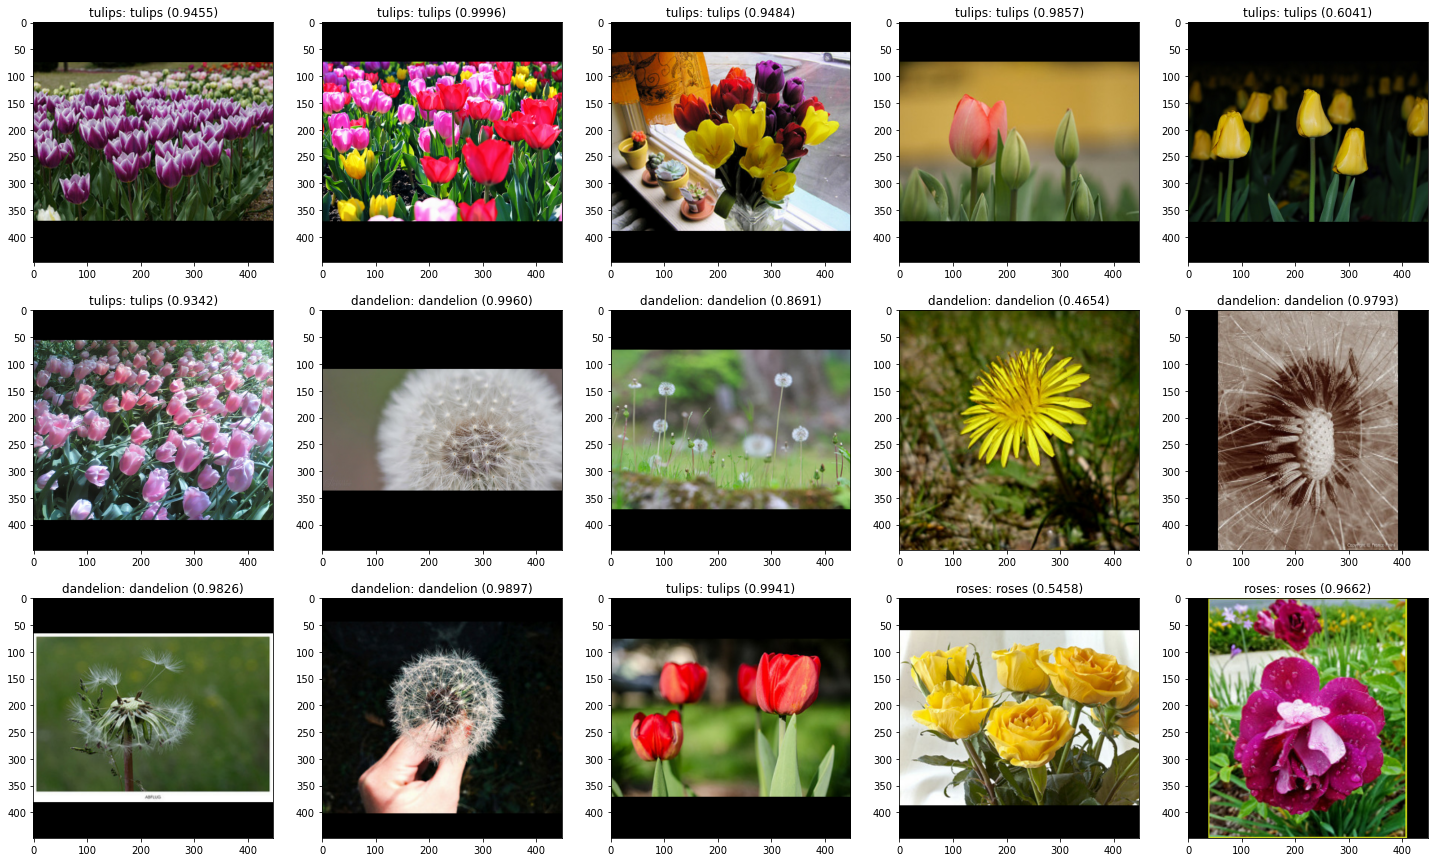

In [11]:
# Call model.predict() on a few images in evaluation dataset
def plot_predictions(model, pattern):
    dataset = create_preproc_dataset(pattern)
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    for idx, (img, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow((img.numpy()));
        batch_image = tf.reshape(img, [1, 2*IMG_HEIGHT, 2*IMG_WIDTH, IMG_CHANNELS])
        batch_pred = model.predict(batch_image)
        pred = batch_pred[0]
        label = CLASS_NAMES[label.numpy()]
        pred_label_index = tf.math.argmax(pred).numpy()
        pred_label = CLASS_NAMES[pred_label_index]
        prob = pred[pred_label_index]
        ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

plot_predictions(model, 'gs://practical-ml-vision-book-data/flowers_tfr/valid-*')

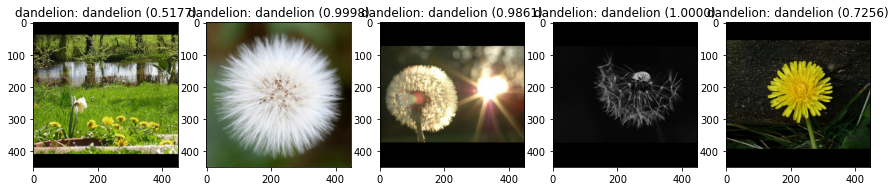

In [12]:
## but actually, for prediction, we won't TensorFlow Records.
## this is how we'd predict for individual images
## (actually, we'll create a serving function: we'll look at that in a later chapter)
filenames = [
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/98992760_53ed1d26a9.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9939430464_5f5861ebab.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9965757055_ff01b5ee6f_n.jpg'
]
label = 'dandelion'
input_images = [create_preproc_image(f) for f in filenames]
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, img in enumerate(input_images):
    ax[idx].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, 2*IMG_HEIGHT, 2*IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

注：精度が低いのは、学習ループがこのノートブックの焦点ではないため、数枚の画像のみでの画像を行ったためです。

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.